<a href="https://colab.research.google.com/github/jyryu3161/DrugDiscovery/blob/main/Lec11_code_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning

### LBDD

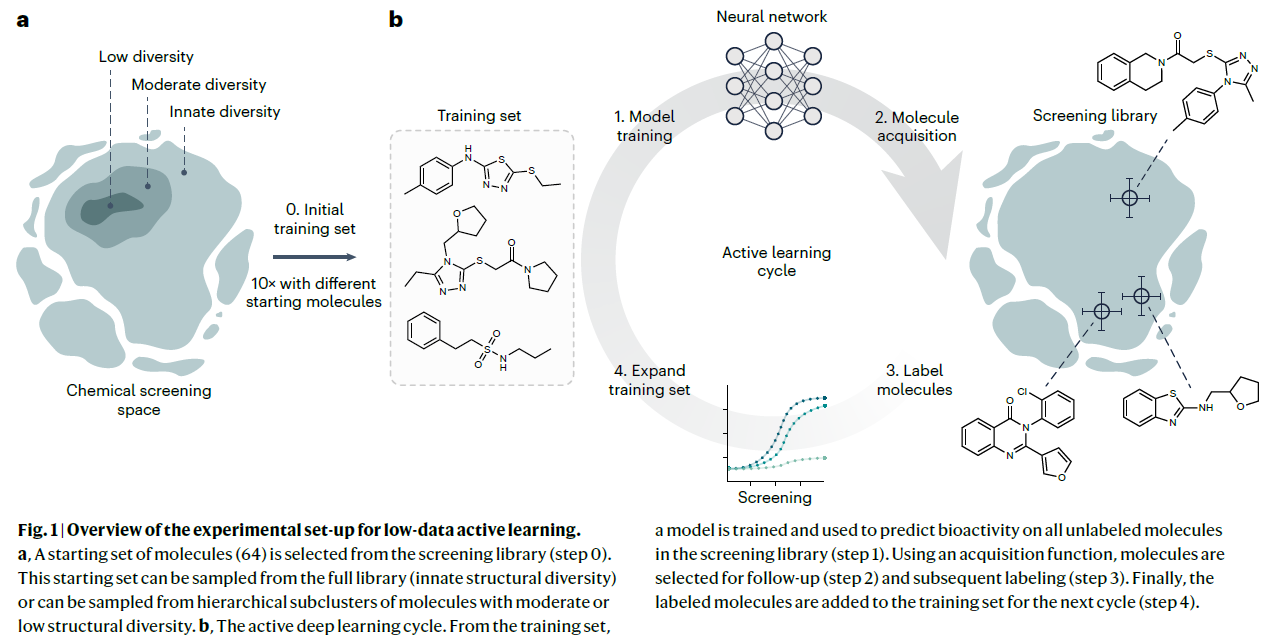

- Active learning은 전통적인 스크리닝 방법들에 비해 발견된 생물학적 활성 분자(hit)의 수를 크게 증가
- One-shot virtual screening(한 번에 모든 분자를 스크리닝하는 방식)과 비교했을 때, active learning은 2-4배 더 높은 enrichment
- 매우 적은 초기 데이터(2-4개의 분자)로 시작했을 때도, active learning은 여전히 상당히 효과적
- Active learning은 여러 주기(5회 이상)에 걸쳐 스크리닝을 수행할 때 더 효과적이었음

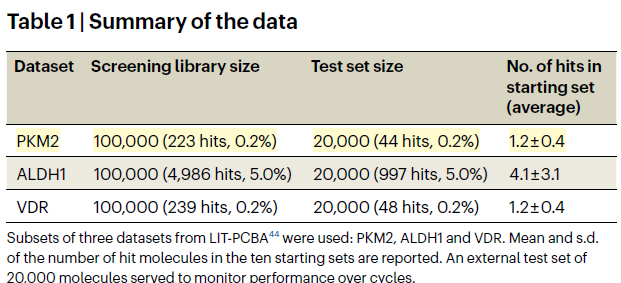

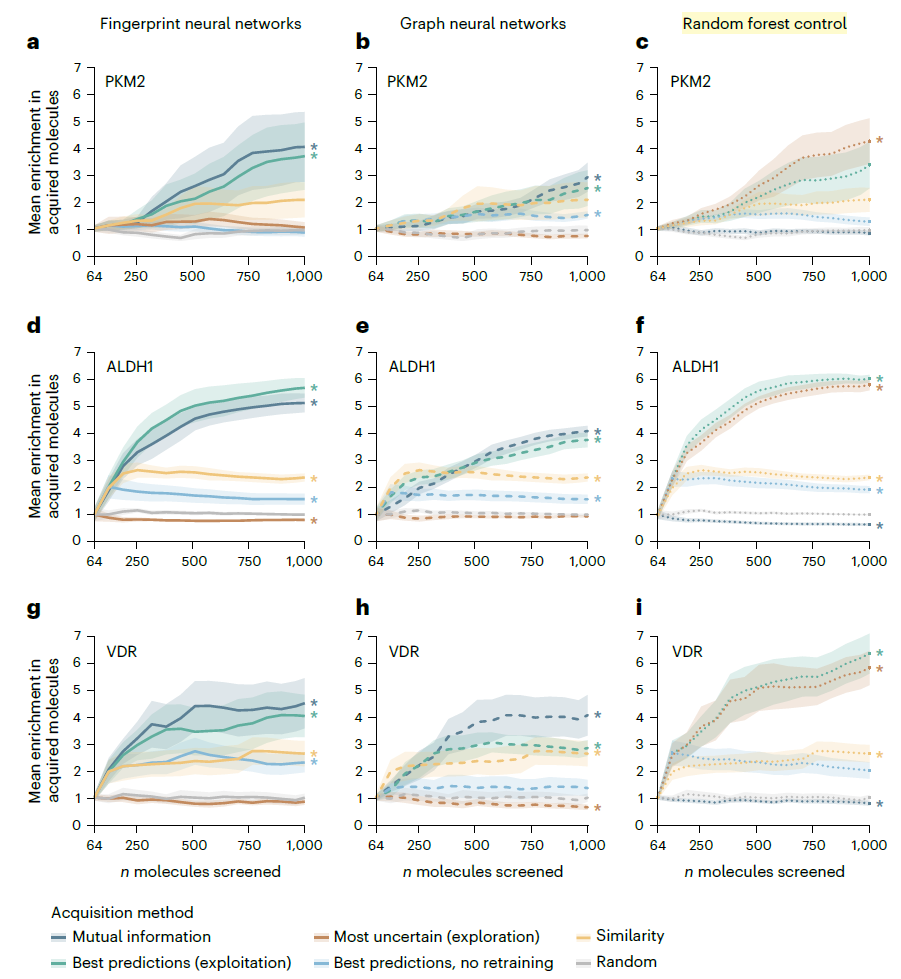

Installation

In [1]:
!pip install rdkit-pypi xgboost deepchem imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 10.7 MB/s eta 0:00:00


Download datasets

In [2]:
!wget -O dataset.zip https://www.dropbox.com/scl/fo/elpijfmrv564hzru5e03d/AFrWRjN0hW0xzN3c18CmlFQ?rlkey=xy3n9l0hwspi112hkdp1pn2fq&st=0g7wbpnt&dl=0 # 데이터셋 다운로드
!unzip dataset.zip

--2025-05-28 07:29:16--  https://www.dropbox.com/scl/fo/elpijfmrv564hzru5e03d/AFrWRjN0hW0xzN3c18CmlFQ?rlkey=xy3n9l0hwspi112hkdp1pn2fq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc621d8c1a6c1b8532e38cdce942.dl.dropboxusercontent.com/zip_download_get/CN4ZX2r9gCnxai-LlfzkP0eZYhuRyvWieb1GFeYhvQ7lvaNC4qtk5Fz7tbXAn-MUKItBpTmTQwjsbjozU7Nj_Tsjc-pVga1P1nRDObE5Y6vDng# [following]
--2025-05-28 07:29:17--  https://uc621d8c1a6c1b8532e38cdce942.dl.dropboxusercontent.com/zip_download_get/CN4ZX2r9gCnxai-LlfzkP0eZYhuRyvWieb1GFeYhvQ7lvaNC4qtk5Fz7tbXAn-MUKItBpTmTQwjsbjozU7Nj_Tsjc-pVga1P1nRDObE5Y6vDng
Resolving uc621d8c1a6c1b8532e38cdce942.dl.dropboxusercontent.com (uc621d8c1a6c1b8532e38cdce942.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc621d8c1a6c1b8532e38cdce942.dl.dropbo

Data reduction

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 원본 데이터 로드
screen_df = pd.read_csv('./ALDH1/original/screen.csv')
test_df = pd.read_csv('./ALDH1/original/test.csv')

# screen_df에서 35000 샘플 추출 (30000 for train + 5000 for valid)
screen_sample, _ = train_test_split(screen_df, train_size=30000, stratify=screen_df['y'], random_state=42)

# test_df에서 5000개 샘플 추출
test_sample, _ = train_test_split(test_df, train_size=5000, stratify=test_df['y'], random_state=42)

# 결과 출력
print("원본 Screen 데이터의 hit 수:", len(screen_df[screen_df['y']==1]))
print("샘플링된 Train 데이터의 hit 수:", len(screen_sample[screen_sample['y']==1]))
print("샘플링된 Train 데이터의 총 개수:", len(screen_sample))

print("\n원본 Test 데이터의 hit 수:", len(test_df[test_df['y']==1]))
print("샘플링된 Test 데이터의 hit 수:", len(test_sample[test_sample['y']==1]))
print("샘플링된 Test 데이터의 총 개수:", len(test_sample))

# 샘플링된 데이터를 새 CSV 파일로 저장
screen_sample.to_csv('./sampled_train.csv', index=False)
test_sample.to_csv('./sampled_test.csv', index=False)

원본 Screen 데이터의 hit 수: 4986
샘플링된 Train 데이터의 hit 수: 1496
샘플링된 Train 데이터의 총 개수: 30000

원본 Test 데이터의 hit 수: 997
샘플링된 Test 데이터의 hit 수: 249
샘플링된 Test 데이터의 총 개수: 5000


In [5]:
import numpy as np
import pandas as pd
from rdkit import Chem
from deepchem.feat import CircularFingerprint
from rdkit import RDLogger
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample
import copy

from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

RDLogger.logger().setLevel(RDLogger.ERROR)


class RandomForestEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, base_params=None):
        self.n_estimators = n_estimators
        self.base_params = base_params or {}
        self.estimators = []

        for i in range(n_estimators):
            params = self.base_params.copy()
            params.update({
                'n_estimators': np.random.randint(10, 100),
                'max_depth': np.random.randint(3, 10),
                'min_samples_split': np.random.randint(2, 20),
                'min_samples_leaf': np.random.randint(1, 10),
                'max_features': np.random.uniform(0.5, 1.0),
                'bootstrap': True,
                'random_state': np.random.randint(0, 10000)
            })
            self.estimators.append(RandomForestClassifier(**params))

    def fit(self, X, y):
        for estimator in self.estimators:
            estimator.fit(X, y)

    def predict_proba(self, X):
        probas = []
        for estimator in self.estimators:
            probas.append(estimator.predict_proba(X))
        return np.mean(probas, axis=0)

    def predict_proba_with_variance(self, X):
        probas = []
        for estimator in self.estimators:
            probas.append(estimator.predict_proba(X)[:, 1])
        probas = np.array(probas)
        mean_proba = np.mean(probas, axis=0)
        variance = np.var(probas, axis=0)
        return mean_proba, variance

class ActiveLearning:
    def __init__(self, smiles_list, activities, budget=1000, batch_size=64, n_cycles=15, n_estimators=5, initial_exploration_ratio=0.5, min_exploration_ratio=0.05, exploration_decay=0.8):
        self.smiles_list = smiles_list
        self.activities = activities
        self.budget = budget
        self.batch_size = batch_size
        self.n_cycles = n_cycles
        self.model = RandomForestEnsemble(n_estimators=n_estimators)
        self.training_indices = []
        self.screening_indices = list(range(len(smiles_list)))

        self.exploration_ratio = initial_exploration_ratio
        self.min_exploration_ratio = min_exploration_ratio
        self.exploration_decay = exploration_decay

    def update_exploration_ratio(self):
        # cycle마다 exploration ratio를 감소시킴
        self.exploration_ratio = max(self.exploration_ratio * self.exploration_decay, self.min_exploration_ratio)

    def get_fingerprints(self, smiles_list):
        mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
        featurizer = CircularFingerprint(size=2048, radius=2)
        features = featurizer.featurize(mols)
        return np.array(features)

    def initialize(self, n_initial=64):
        hit_indices = [i for i, activity in enumerate(self.activities) if activity == 1]
        if hit_indices:
            first_hit = np.random.choice(hit_indices)
            remaining = n_initial - 1
            self.training_indices = [first_hit]
        else:
            remaining = n_initial
            self.training_indices = []
        non_hit_indices = list(set(range(len(self.activities))) - set(hit_indices))
        self.training_indices.extend(np.random.choice(non_hit_indices, remaining, replace=False))
        self.screening_indices = list(set(range(len(self.smiles_list))) - set(self.training_indices))

    def train_model(self):
        X_train = self.get_fingerprints([self.smiles_list[i] for i in self.training_indices])
        y_train = [self.activities[i] for i in self.training_indices]
        self.model.fit(X_train, y_train)

    def predict(self, indices):
        X = self.get_fingerprints([self.smiles_list[i] for i in indices])
        return self.model.predict_proba(X)

    def acquire_samples(self):
        X = self.get_fingerprints([self.smiles_list[i] for i in self.screening_indices])
        proba, variance = self.model.predict_proba_with_variance(X)

        # Exploitation
        n_exploit = int(self.batch_size * (1 - self.exploration_ratio))
        exploit_indices = np.argsort(proba)[::-1][:n_exploit]

        # Exploration
        n_explore = self.batch_size - n_exploit
        remaining_indices = list(set(range(len(proba))) - set(exploit_indices))
        explore_indices = np.argsort(variance[remaining_indices])[::-1][:n_explore]
        explore_indices = [remaining_indices[i] for i in explore_indices]

        selected_indices = list(exploit_indices) + list(explore_indices)
        selected_indices = [self.screening_indices[i] for i in selected_indices]

        self.training_indices.extend(selected_indices)
        self.screening_indices = list(set(self.screening_indices) - set(selected_indices))

    def evaluate_screening(self):
        screening_preds = self.predict(self.screening_indices)[:, 1]
        sorted_indices = np.argsort(screening_preds)[::-1]

        original_hit_rate = sum([self.activities[i] for i in self.screening_indices]) / len(self.screening_indices)

        top_n = min(self.batch_size, len(self.screening_indices))
        top_hits = sum([self.activities[self.screening_indices[i]] for i in sorted_indices[:top_n]])
        predicted_hit_rate = top_hits / top_n

        enrichment_factor = predicted_hit_rate / original_hit_rate if original_hit_rate > 0 else 0

        return original_hit_rate, predicted_hit_rate, enrichment_factor, top_hits

    def run(self):
        self.initialize()
        screening_hit_rates, screening_predicted_hit_rates, screening_enrichment_factors = [], [], []
        cumulative_hits = []

        for cycle in range(self.n_cycles):
            self.train_model()
            self.update_exploration_ratio()
            screening_hr, screening_pred_hr, screening_ef, screening_top_hits = self.evaluate_screening()

            screening_hit_rates.append(screening_hr)
            screening_predicted_hit_rates.append(screening_pred_hr)
            screening_enrichment_factors.append(screening_ef)
            cumulative_hits.append(sum([self.activities[i] for i in self.training_indices]))

            print(f"Cycle {cycle + 1}, Screening Hits: {screening_top_hits}, Screening HR: {screening_pred_hr:.4f}, Screening EF: {screening_ef:.4f}, "
                  f"Training set size: {len(self.training_indices)}, Cumulative Hits: {cumulative_hits[-1]}")

            if len(self.training_indices) >= self.budget:
                break

            self.acquire_samples()

        return (screening_hit_rates, screening_predicted_hit_rates, screening_enrichment_factors, cumulative_hits)

train_df = pd.read_csv('./sampled_train.csv')

smiles_list = train_df['smiles'].tolist()
activities = train_df['y'].tolist()

al_mixed = ActiveLearning(smiles_list, activities, budget=1000, batch_size=64, n_cycles=10, n_estimators=10, initial_exploration_ratio=0.5, min_exploration_ratio=0.05, exploration_decay=0.8)
results = al_mixed.run()

screening_hrs, screening_predicted_hrs, screening_efs, cumulative_hits = results

# 최종 결과 출력
print(f"\nFinal Results:")
print(f"Cumulative Hits: {cumulative_hits[-1]}")
print(f"Final Screening HR: {screening_predicted_hrs[-1]:.4f}")
print(f"Final Screening EF: {screening_efs[-1]:.4f}")

Cycle 1, Screening Hits: 4, Screening HR: 0.0625, Screening EF: 1.2515, Training set size: 64, Cumulative Hits: 1
Cycle 2, Screening Hits: 0, Screening HR: 0.0000, Screening EF: 0.0000, Training set size: 128, Cumulative Hits: 8
Cycle 3, Screening Hits: 9, Screening HR: 0.1406, Screening EF: 2.8170, Training set size: 192, Cumulative Hits: 8
Cycle 4, Screening Hits: 12, Screening HR: 0.1875, Screening EF: 3.7810, Training set size: 256, Cumulative Hits: 21
Cycle 5, Screening Hits: 17, Screening HR: 0.2656, Screening EF: 5.3924, Training set size: 320, Cumulative Hits: 34
Cycle 6, Screening Hits: 21, Screening HR: 0.3281, Screening EF: 6.7112, Training set size: 384, Cumulative Hits: 48
Cycle 7, Screening Hits: 25, Screening HR: 0.3906, Screening EF: 8.0895, Training set size: 448, Cumulative Hits: 69
Cycle 8, Screening Hits: 21, Screening HR: 0.3281, Screening EF: 6.8916, Training set size: 512, Cumulative Hits: 92
Cycle 9, Screening Hits: 15, Screening HR: 0.2344, Screening EF: 4.9756